In [4]:
import full_model
import fast_model
import fast_model_improved
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import pickle

## Load the model

In [5]:
# Load the graph from the file
save_path = '/Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/email_eu_core_graph.gpickle'
try:
    with open(save_path, 'rb') as f:
        G_email = pickle.load(f)
    print(f"Graph loaded from {save_path}")
except Exception as e:
    print(f"An error occurred while loading the graph: {e}")

# Display basic information about the graph
print(f"Number of nodes: {G_email.number_of_nodes()}")
print(f"Number of edges: {G_email.number_of_edges()}")
print(f"Average degree: {sum(dict(G_email.degree()).values()) / G_email.number_of_nodes():.2f}")

# Perform additional operations on the graph
# Example: Print the neighbors of node 0
if 0 in G_email:
    print(f"Neighbors of node 0: {list(G_email.neighbors(0))}")
else:
    print("Node 0 is not in the graph")

Graph loaded from /Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/email_eu_core_graph.gpickle
Number of nodes: 1005
Number of edges: 25571
Average degree: 50.89
Neighbors of node 0: [1, 316, 146, 268, 581, 221, 18, 734, 178, 380, 0, 459, 215, 250, 148, 73, 498, 226, 101, 218, 377, 17, 74, 177, 248, 103, 560, 309, 88, 5, 297, 313, 223, 238, 368, 266, 222, 283, 6, 64, 166]


In [3]:
def generate_and_find_inf(steps, num_influencers=0):

    model_inf = fast_model_improved.InfluenceDeinfluenceModel(G_email)
    model_inf.set_initial_states()
    initial_influencers = model_inf.greedy_hill_climbing(num_influencers, steps)

    #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
    print("Optimized Initial Influencers:", initial_influencers)

    return model_inf, initial_influencers

In [4]:
inf_steps = 3
num_influencers = 5

results = generate_and_find_inf(inf_steps, num_influencers=num_influencers)

(model_inf, optimized_influencers) = results

#print("count influence", model.evaluate_influence())

Optimized Initial Influencers: {160, 547, 107, 82, 381}


In [5]:
deinf_steps = 3
deinf_num = 3

model = full_model.InfluenceDeinfluenceModel(model_inf.graph)
model.history = []
model.selected_influencers = optimized_influencers
print("Optimized Influencers:", optimized_influencers)

model.set_initial_states()
deinfluencers = model.greedy_hill_climbing_deinf(deinf_num, 5)
print("Optimized Deinfluencers:", deinfluencers)

model.reset_graph()
model.set_influencers(optimized_influencers)
model.set_deinfluencers(deinfluencers)
model.run_cascade(deinf_steps)

print("count deinfuence",model.count_deinfluenced())

Optimized Influencers: {160, 547, 107, 82, 381}
Optimized Deinfluencers: {160, 660, 181}
count deinfuence 901


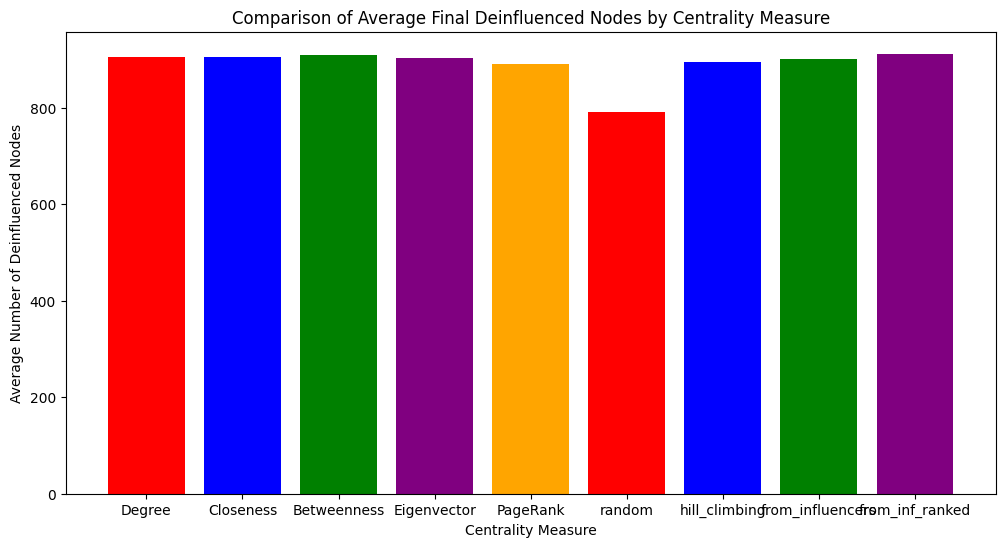

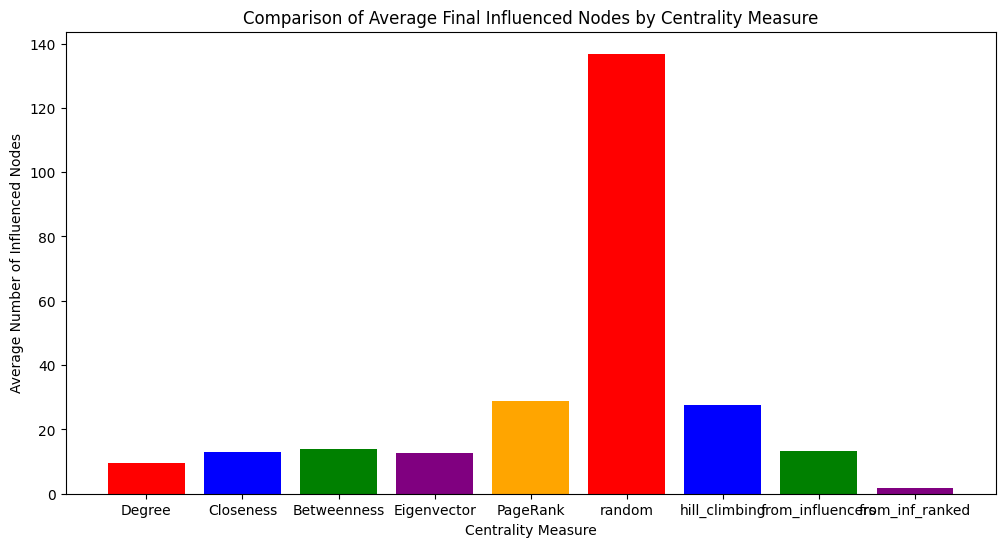

In [11]:
model = full_model.InfluenceDeinfluenceModel(G_email)

optimized_influencers = {160, 547, 107, 82, 381}
optimized_deinfluencers = {160, 660, 181}

model.set_initial_states()
model.set_influencers(optimized_influencers)
model.selected_influencers = optimized_influencers
model.set_deinfluencers(optimized_deinfluencers)


# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        deinfluenced_count = model.count_deinfluenced()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_deinfluenced += deinfluenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_deinfluenced

def count_influenced(model, inf, deinf, num_runs, steps):
    total_influenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        influenced_count = model.evaluate_influence()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_influenced += influenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_influenced = total_influenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_influenced

# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 3

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
optimized_deinfluencers = {160, 660, 181}
deinfleucers_from_influencers = model.select_deinfluencers_from_influencers(k_deinfluencers)
ranked_deinfleucers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)


# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 10  # Number of times to run the cascade for averaging
steps = 3  # Number of steps to run the cascade

results_d = {
    'Degree': count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    'hill_climbing': count_deinfluenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_deinfluenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_deinfluenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_i = { 
    'Degree': count_influenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_influenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_influenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_influenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_influenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_influenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    'hill_climbing': count_influenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_influenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_influenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}



# Print the results
#for centrality, count in results.items():
    #print(f"{centrality}: {count:.2f} nodes deinfluenced on average")

# Plot the results
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()

plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()
